# Reinforcement Learning Modular Framework

Let's assemble much of the code from previous lectures on reinforcement learning into several classes.  This will clearly separate the environment from the agent in a reinforcement learning setting.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import neuralnetworksA4 as nn

from topic_banner import new_topic

First, we define two classes that just define the functions we need to define an `Environment` and an `Agent`.

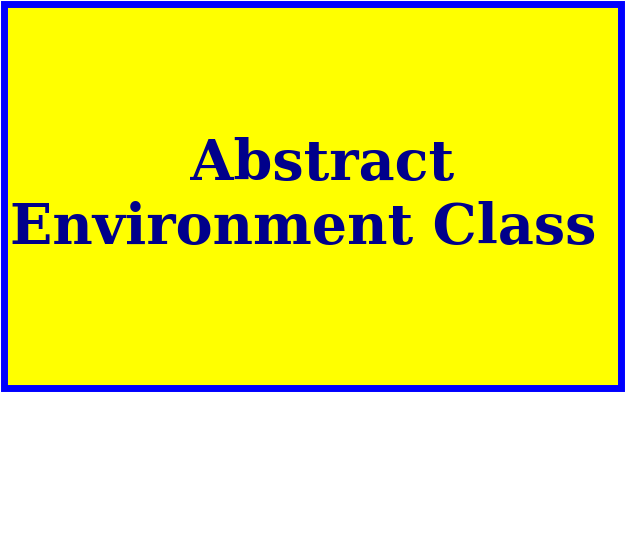

In [4]:
new_topic('Abstract Environment Class')

In [5]:
from abc import ABC, abstractmethod
    
class Environment(ABC):
    
    @abstractmethod
    def __init__(self):
        pass
        # ...

    @abstractmethod
    def initialize(self):
        self.state = None
        ...
        
    @abstractmethod
    def valid_actions(self):
        pass
        # return list of valid actions based on self.state
        
    @abstractmethod
    def observe(self):
        pass
        # return what agent can observe about current self.state
    
    @abstractmethod
    def act(self, action):
        self.state = self.state.copy()
        # ...
    
    @abstractmethod
    def reinforcement(self):
        # r = some function of self.state
        return r # scalar reinforcement
   
    @abstractmethod
    def terminal_state(self, state):
        return False  # True if state is terminal state
    
    @abstractmethod
    def __str__(self):
        pass
        # return string to print current self.state
        
    def __repr__(self):
        return self.__str__()

If abstract methods are not defined in a class derived from `Environment`, we cannot instantiate an instance of that class.

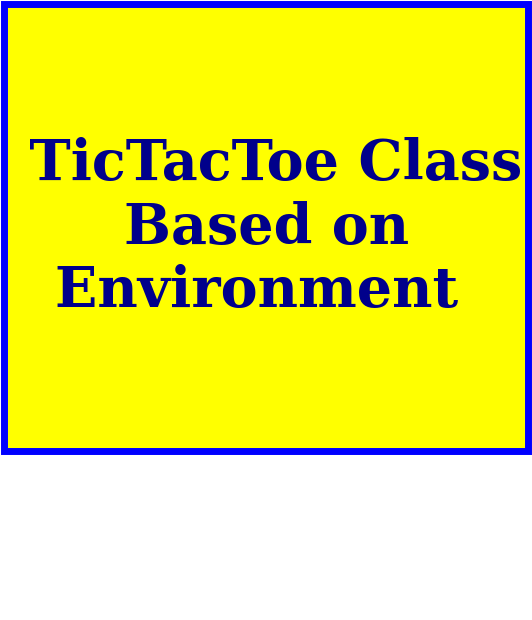

In [6]:
new_topic('TicTacToe Class Based on Environment')

In [7]:
class TicTacToe(Environment):

    def __init__(self):
        self.state = None
        self.observation_size = 9
        self.action_size = 1
        self.player = 'X'

        self.observation_means = [0] * 9
        self.observation_stds = [0.8] * 9
        self.action_means = [4]
        self.action_stds =  [2.5]
        self.Q_means = [0]
        self.Q_stds = [1]
        
    def initialize(self):
        self.state = np.array([0] * 9)
        self.player = 'X'
        
    def act(self, action): 
        self.state = self.state.copy()
        self.state[action] = 1 if self.player == 'X' else -1
        self.player = 'X' if self.player == 'O' else 'O'

    def observe(self):
        return self.state

    def reinforcement(self):
        if self._won('X'):
            return 1
        if self._won('O'):
            return -1
        return 0

    def valid_actions(self):
        return np.where(self.state == 0)[0]

    def _won(self, player):
        marker = 1 if player == 'X' else -1  # flipped player because already set to next player
        combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
        return np.any(np.all(marker == self.state[combos].reshape((-1, 3)), axis=1))

    def _draw(self):
        return len(self.valid_actions()) == 0

    def terminal_state(self):
        return self._won('X') or self._won('O') or self._draw()

    def __str__(self):
        markers = np.array(['O', ' ', 'X'])
        s = '''
    {}|{}|{}
    -----
    {}|{}|{}
    ------
    {}|{}|{}'''.format(*markers[1 + self.state])
        return s

    def __repr__(self):
        return self.__str__()
    


Try creating an instance of this class and test some of the methods.

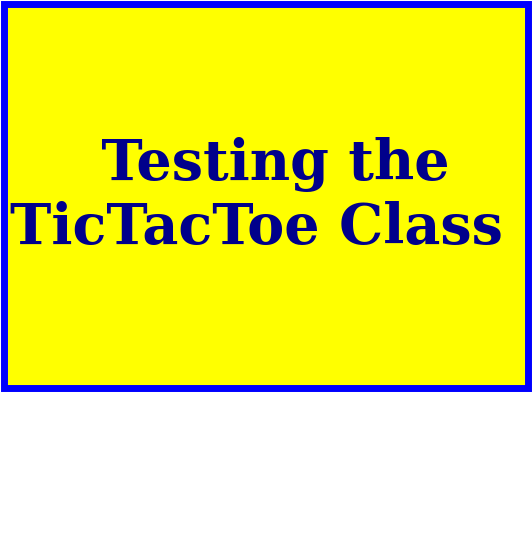

In [8]:
new_topic('Testing the TicTacToe Class')

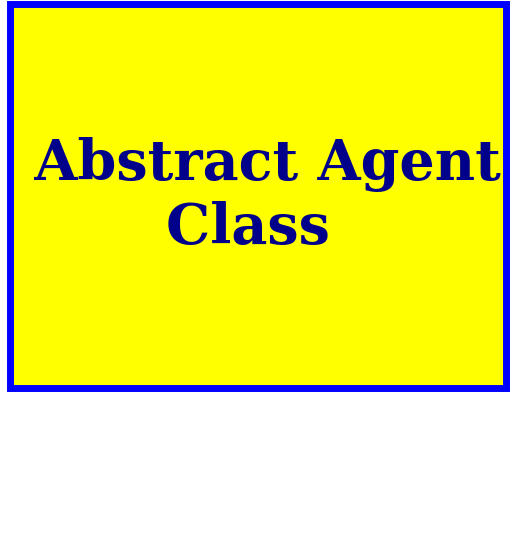

In [9]:
new_topic('Abstract Agent Class')

Now we can define an abstract class for a generic `Agent`.

In [10]:
class Agent(ABC):
    
    def __init__(self, environment, n_hiddens_each_layer, max_or_min='max'):
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.env = environment
        self.R_sign = 1 if max_or_min == 'max' else -1
        self.initialize()
        
    @abstractmethod
    def initialize(self):
        pass
    
    def epsilon_greedy(self, epsilon):

        actions = self.env.valid_actions()

        if np.random.uniform() < epsilon:
            # Random Move
            action = np.random.choice(actions)

        else:
            # Greedy Move
            np.random.shuffle(actions)
            obs = self.env.observe()
            Qs = np.array([self.use(np.hstack((obs, a))) for a in actions])
            action = actions[np.argmax(Qs)]

        return action
    
    def clear_samples(self):
        self.X = []
        self.R = []
        self.Done = []
        
    def add_sample(self, obs, action, r, done):
        self.X.append(np.hstack((obs, action)))
        self.R.append(r)
        self.Done.append(done)

    def update_Qn(self):

        env = self.env
        env.initialize()

        self.X = np.vstack(self.X)
        self.R = np.array(self.R).reshape(-1, 1)
        self.Done = np.array(self.Done).reshape(-1, 1)

        Qn = np.zeros_like(self.R)

        last_steps = np.where(self.Done)[0]
        first = 0
        for last_step in last_steps:
            Qn[first:last_step] = self.use(self.X[first:last_step])
            first += last_step

        return Qn 

    @abstractmethod
    def train(self, n_epochs, method, learning_rate):
        gamma = 0.9

        for epoch in range(n_epochs):
            Qn = self.update_Qn()
            T = self.R_sign * self.R + gamma * Qn
            # ...Use following if neural net                                
            self.Qnet.train(self.X, T, self.X, T,
                            n_epochs=1, method=method, learning_rate=learning_rate, verbose=False)

    @abstractmethod
    def use(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        return # calculate Q values for each row of X, each consisting of state and action

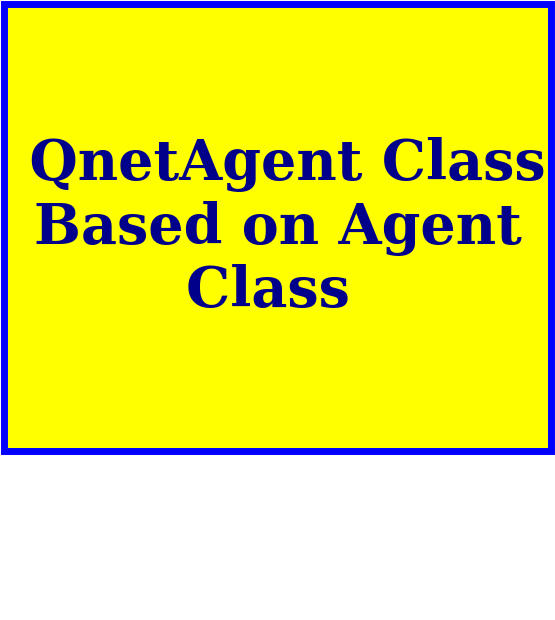

In [11]:
new_topic('QnetAgent Class Based on Agent Class')

In [21]:
class QnetAgent(Agent):
    
    def __init__(self, environment, n_hiddens_each_layer, max_or_min='max'):
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.env = environment
        self.R_sign = 1 if max_or_min == 'max' else -1
        self.initialize()
        
    def initialize(self):
        env = self.env
        ni = env.observation_size + env.action_size
        self.Qnet = nn.NeuralNetwork(ni, self.n_hiddens_each_layer, 1)
        self.Qnet.X_means = np.array(env.observation_means + env.action_means)
        self.Qnet.X_stds = np.array(env.observation_stds + env.action_stds)
        self.Qnet.T_means = np.array(env.Q_means)
        self.Qnet.T_stds = np.array(env.Q_stds)

    def epsilon_greedy(self, epsilon):

        actions = self.env.valid_actions()

        if np.random.uniform() < epsilon:
            # Random Move
            action = np.random.choice(actions)

        else:
            # Greedy Move
            np.random.shuffle(actions)
            obs = self.env.observe()
            Qs = np.array([self.use(np.hstack((obs, a))) for a in actions])
            action = actions[np.argmax(Qs)]

        return action

    def use(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        return self.Qnet.use(X)

    def clear_samples(self):
        self.X = []
        self.R = []
        self.Done = []

    def add_sample(self, obs, action, r, done):
        self.X.append(np.hstack((obs, action)))
        self.R.append(r)
        self.Done.append(done)

    def update_Qn(self):

        env = self.env
        env.initialize()

        self.X = np.vstack(self.X)
        self.R = np.array(self.R).reshape(-1, 1)
        self.Done = np.array(self.Done).reshape(-1, 1)

        Qn = np.zeros_like(self.R)

        last_steps = np.where(self.Done)[0]
        first = 0
        for last_step in last_steps:
            Qn[first:last_step - 1] = self.use(self.X[first + 1:last_step])
            first = last_step

        return Qn 

    def train(self, n_epochs, method, learning_rate):
        gamma = 0.9

        for epoch in range(n_epochs):

            Qn = self.update_Qn()
            # R is from Player X's perspective. Negate it for Player O.
            T = self.R_sign * self.R + gamma * Qn
            self.Qnet.train(self.X, T, self.X, T,
                            n_epochs=1, method=method, learning_rate=learning_rate, verbose=False)
            
    def __str__(self):
        return self.Qnet.__str__()
    
    def __repr__(self):
        return self.__str__()

Now create an instance of this agent and test some of the function.

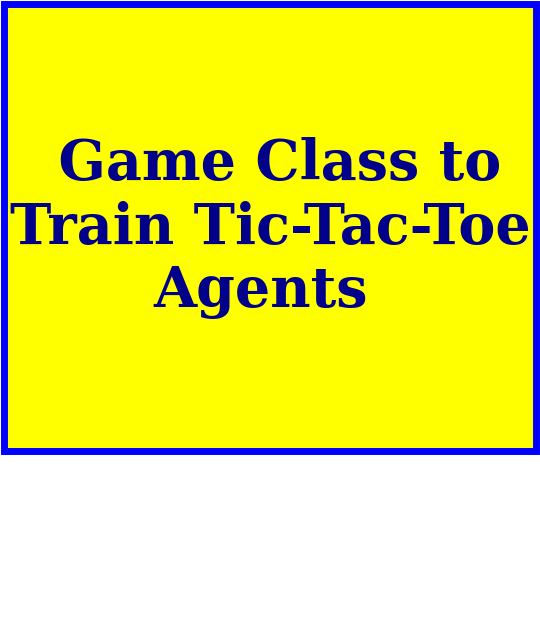

In [22]:
new_topic('Game Class to Train Tic-Tac-Toe Agents')

In [23]:
class Game:

    def __init__(self, environment, agents):

        self.env = environment
        self.agents = agents

    def train(self, parms):

        n_batches = parms['n_batches']
        n_trials_per_batch = parms['n_trials_per_batch']
        n_epochs = parms['n_epochs']
        method = parms['method']
        learning_rate = parms['learning_rate']

        env = self.env

        final_epsilon = 0.01
        epsilon_decay =  np.exp(np.log(final_epsilon) / (n_batches)) # to produce this final value
        epsilon = 1.0
        
        epsilon_trace = []
        outcomes = []

        for batch in range(n_batches):
            agents['X'].clear_samples()
            agents['O'].clear_samples()
            
            for trial in range(n_trials_per_batch):

                env.initialize()
                done = False

                while not done:

                    agent = agents[env.player]
                    obs = self.env.observe()
                    action = agent.epsilon_greedy(epsilon)

                    env.act(action)
                    r = env.reinforcement()
                    done = env.terminal_state()

                    # print(env)
                    # print(r)

                    agent.add_sample(obs, action, r, done)

                outcomes.append(r)

            # end n_trials_per_batch
            self.agents['X'].train(n_epochs, method, learning_rate)
            self.agents['O'].train(n_epochs, method, learning_rate)

            epsilon_trace.append(epsilon)
            epsilon *= epsilon_decay

            if len(outcomes) % ((n_batches * n_trials_per_batch) // 20) == 0:
                print(f'{len(outcomes)} games, {np.mean(outcomes):.2f} outcome mean')

        plt.figure(1)
        plt.clf()
        plt.subplot(3, 1, 1)
        n_per = 10
        n_bins = len(outcomes) // n_per
        outcomes_binned = np.array(outcomes).reshape(-1, n_per)
        avgs = outcomes_binned.mean(1)
        xs = np.linspace(n_per, n_per * n_bins, len(avgs))
        plt.plot(xs, avgs)
        plt.axhline(y=0, color='orange', ls='--')
        plt.ylabel('R')
        
        plt.subplot(3, 1, 2)
        plt.plot(xs, np.sum(outcomes_binned == -1, axis=1), 'r-', label='O Wins')
        plt.plot(xs, np.sum(outcomes_binned == 0, axis=1), 'b-', label='Draws')
        plt.plot(xs, np.sum(outcomes_binned == 1, axis=1), 'g-', label='X Wins')
        plt.legend(loc='center')
        plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
        plt.subplot(3, 1, 3)
        plt.plot(epsilon_trace)
        plt.ylabel('$\epsilon$')

        return outcomes, epsilon_trace

In [24]:
def plot_outcomes(outcomes, epsilons, n_trials, trial):
    outcomes = np.array(outcomes)
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
    outcome_rows = outcome_rows[:trial // n_per + 1, :]
    avgs = np.mean(outcome_rows, axis=1)

    plt.figure(1)
    plt.clf()
    plt.subplot(3, 1, 1)
    plt.plot(xs, avgs, 'g-')
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=X win, -1=O win)')
    plt.title(f'Bins of {n_per:d} Games')

    plt.subplot(3, 1, 2)
    xs = np.linspace(n_per, n_per * n_bins, len(avgs))
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label='Wins')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label='Losses')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:trial])
    plt.ylabel('$\epsilon$')

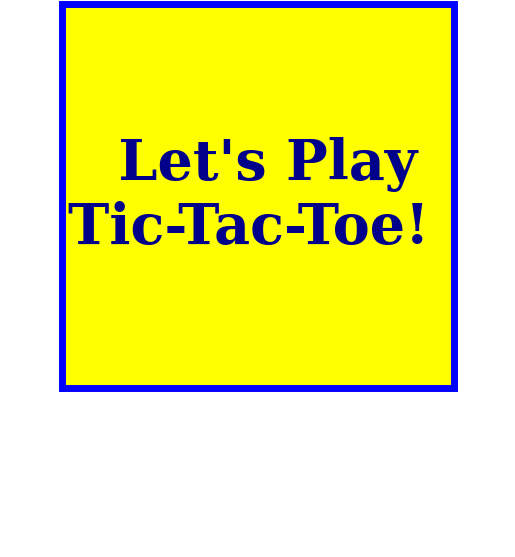

In [25]:
new_topic('Let\'s Play Tic-Tac-Toe!')

400 games, 0.29 outcome mean
800 games, 0.30 outcome mean
1200 games, 0.33 outcome mean
1600 games, 0.35 outcome mean
2000 games, 0.37 outcome mean
2400 games, 0.40 outcome mean
2800 games, 0.41 outcome mean
3200 games, 0.44 outcome mean
3600 games, 0.46 outcome mean
4000 games, 0.48 outcome mean
4400 games, 0.50 outcome mean
4800 games, 0.53 outcome mean
5200 games, 0.55 outcome mean
5600 games, 0.57 outcome mean
6000 games, 0.59 outcome mean
6400 games, 0.61 outcome mean
6800 games, 0.63 outcome mean
7200 games, 0.64 outcome mean
7600 games, 0.66 outcome mean
8000 games, 0.67 outcome mean


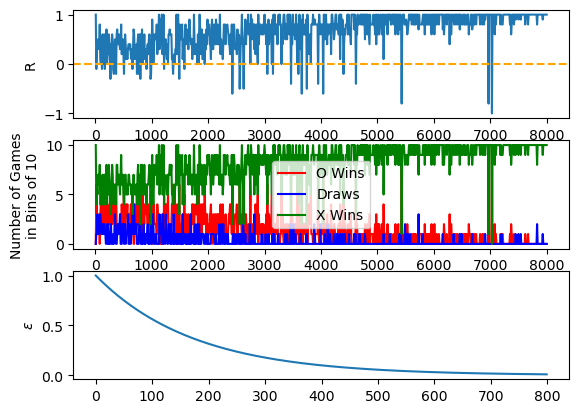

In [28]:
ttt = TicTacToe()
agents = {'X': QnetAgent(ttt, [20, 20], 'max'), 'O': QnetAgent(ttt, [], 'min')}
game = Game(ttt, agents)

parms = {
    'n_batches': 800,
    'n_trials_per_batch': 10,
    'n_epochs': 5,
    'method': 'sgd',
    'learning_rate': 0.2
}

outcomes = game.train(parms)